In [38]:
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
from torch.utils.data import DataLoader,Subset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Dataset

In [21]:
ROOT_PATH = "/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer"

BATCH_SIZE = 64
SHUFFLE = True
NUM_WORKERS = 2

IMAGE_SIZE = (224, 244)

HORIZ_FLIP_PROB = 0.1
DEGRESS = 0
TRANSLATE = (0.05, 0.05)
SCALE = (0.95, 1.05)
SHEAR = 5

EPOCHS = 30
LEARNING_RATE = 0.001
DECAY = 0.01

DEFAULT_TRANSFORM = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

In [22]:
dataset = datasets.ImageFolder(
    root=ROOT_PATH,
    transform=DEFAULT_TRANSFORM
)
loader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=SHUFFLE, 
    num_workers=NUM_WORKERS
)

In [23]:
mean_channels = torch.zeros(3)
std_channels = torch.zeros(3)
total_images = 0

# ? Cálculo da média e desvio padrão
with torch.no_grad():
    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)  # [BATCH, CHANNEL, HEIGHT*WEIGHT]
        
        mean_channels += images.mean(2).sum(0)
        std_channels += images.std(2).sum(0)
        total_images += batch_size

mean = mean_channels / total_images
std = std_channels / total_images
MEAN = mean.sum(0) / len(mean)
STD = std.sum(0) / len(std)

print("Mean:", MEAN)
print("Std:", STD)

Mean: tensor(0.1544)
Std: tensor(0.1646)


# Preprocessing

In [24]:
TRAIN_TRANSFORM = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),             
    transforms.Resize(IMAGE_SIZE),                          

    transforms.RandomHorizontalFlip(p=HORIZ_FLIP_PROB),                  
    transforms.RandomAffine(
        degrees=DEGRESS,                                           
        translate=TRANSLATE,                              
        scale=SCALE,                                  
        shear=SHEAR                                              
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

VAL_TRANSFORM = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

TEST_TRANSFORM = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [25]:
#Train test split

total_size = len(dataset)

train_size = int(0.9 * total_size)
val_size = int(0.05 * total_size)
test_size = total_size - train_size - val_size 

indices = list(range(total_size))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

In [26]:
train_dataset = datasets.ImageFolder(
    root=ROOT_PATH,
    transform=TRAIN_TRANSFORM
)

val_dataset = datasets.ImageFolder(
    root=ROOT_PATH, 
    transform=VAL_TRANSFORM
)

test_dataset = datasets.ImageFolder(
    root=ROOT_PATH, 
    transform=TEST_TRANSFORM
)

In [27]:
train_data = Subset(train_dataset, train_indices)
val_data = Subset(val_dataset, val_indices)
test_data = Subset(test_dataset,test_indices)

n_iters = EPOCHS * (len(train_data) // BATCH_SIZE) 

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=SHUFFLE)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=SHUFFLE)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=SHUFFLE)

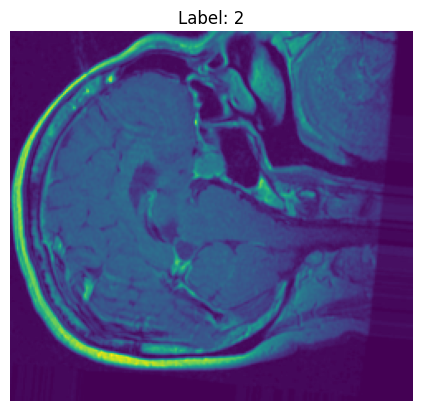

Train dataset: 5450
Validation dataset: 302
Test dataset: 304


In [28]:
img, label = val_data[0]
plt.imshow(img.permute(1, 2, 0))  
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

print(f"Train dataset: {len(train_data)}")
print(f"Validation dataset: {len(val_data)}")
print(f"Test dataset: {len(test_data)}")

In [29]:
print(f"Labels: {dataset.class_to_idx}")

Labels: {'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}


# CNN Model Definition

In [52]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        batch, c, h, w = x.size()
        proj_query = self.query(x).view(batch, -1, h * w).permute(0, 2, 1)
        proj_key = self.key(x).view(batch, -1, h * w)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        
        proj_value = self.value(x).view(batch, -1, h * w)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch, c, h, w)
        
        out = self.gamma * out + x
        return out


class CNNWithSelfAttention(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNWithSelfAttention, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (B,16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,16,112,112)

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,32,56,56)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,64,28,28)
        )
        
        self.attention = SelfAttention(in_channels=64)

        # AdaptiveAvgPool2d para gerar saída (B,64,1,1) independente do tamanho
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.attention(x)
        x = self.pool(x)  # garante shape fixo (B,64,1,1)
        x = x.view(x.size(0), -1)  # flatten para (B,64)
        x = self.classifier(x)
        return x

In [53]:
model = CNNWithSelfAttention()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = LEARNING_RATE #0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=DECAY)

In [54]:
print(model)

CNNWithSelfAttention(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (attention): SelfAttention(
    (query): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (key): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
   

# Model Training

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = error 

# Metrics
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}

for epoch in range(EPOCHS):
    # ---- TRAINING ----
    model.train()
    train_loss_sum = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_loss_avg = train_loss_sum / len(train_loader)
    train_acc = 100 * train_correct / train_total

    # ---- VALIDATION ----
    model.eval()
    val_loss_sum = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()

            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss_avg = val_loss_sum / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # ---- LOG ----
    history['train_loss'].append(train_loss_avg)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss_avg)
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss_avg:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss_avg:.4f}, Acc: {val_acc:.2f}%")


Epoch [1/30] | Train Loss: 0.7796, Acc: 67.08% | Val Loss: 0.6626, Acc: 71.85%
Epoch [2/30] | Train Loss: 0.5318, Acc: 78.64% | Val Loss: 0.4828, Acc: 81.46%
Epoch [3/30] | Train Loss: 0.4683, Acc: 81.85% | Val Loss: 0.4381, Acc: 82.12%
Epoch [4/30] | Train Loss: 0.4091, Acc: 83.71% | Val Loss: 0.3891, Acc: 86.42%
Epoch [5/30] | Train Loss: 0.3784, Acc: 85.28% | Val Loss: 0.4638, Acc: 83.44%
Epoch [6/30] | Train Loss: 0.3481, Acc: 86.77% | Val Loss: 1.6531, Acc: 48.34%
Epoch [7/30] | Train Loss: 0.3676, Acc: 86.13% | Val Loss: 1.8077, Acc: 50.99%
Epoch [8/30] | Train Loss: 0.3241, Acc: 87.82% | Val Loss: 0.3959, Acc: 83.44%
Epoch [9/30] | Train Loss: 0.2985, Acc: 88.07% | Val Loss: 0.4479, Acc: 82.45%
Epoch [10/30] | Train Loss: 0.2747, Acc: 89.74% | Val Loss: 0.4123, Acc: 81.79%
Epoch [11/30] | Train Loss: 0.2596, Acc: 89.82% | Val Loss: 0.2886, Acc: 89.07%
Epoch [12/30] | Train Loss: 0.2407, Acc: 90.83% | Val Loss: 0.2999, Acc: 88.08%
Epoch [13/30] | Train Loss: 0.2646, Acc: 90.46% |

In [56]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds += preds.cpu().tolist()
        all_labels += labels.cpu().tolist()

In [62]:
from sklearn.metrics import f1_score, recall_score, classification_report

f1 = f1_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')

print(f'F1 Score (Weighted): {f1:.4f}')
print(f'Recall (Weighted): {recall:.4f}')

F1 Score (Weighted): 0.9112
Recall (Weighted): 0.9112


In [63]:
target_names = [str(i) for i in range(3)] 

report = classification_report(all_labels, all_preds, target_names=target_names)
print("\nReport:")
print(report)


Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       103
           1       0.99      0.84      0.91       101
           2       0.97      0.89      0.93       100

    accuracy                           0.91       304
   macro avg       0.92      0.91      0.91       304
weighted avg       0.92      0.91      0.91       304



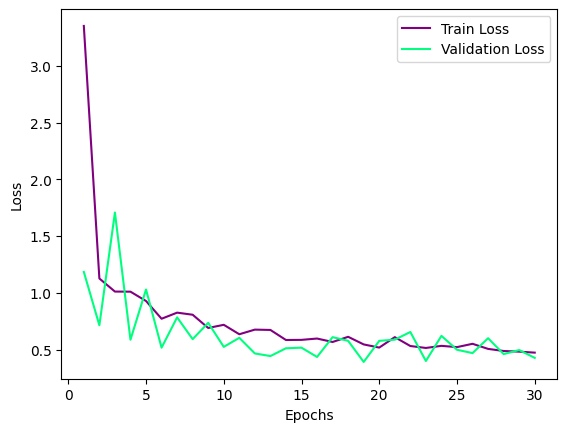

In [69]:
plt.plot(iteration_list, train_loss_list, color="purple", label="Train Loss")
plt.plot(iteration_list, val_loss_list, color="springgreen", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()  
plt.show()

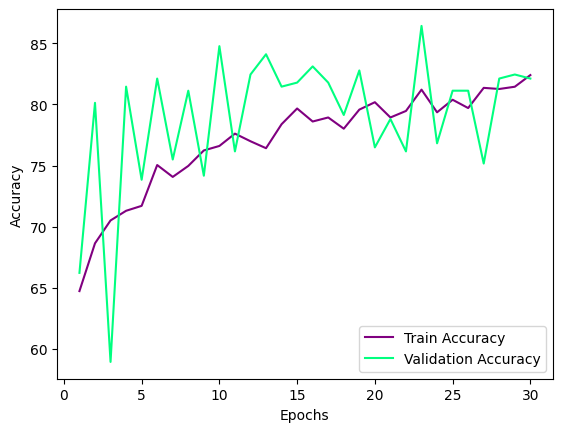

In [70]:
plt.plot(iteration_list, train_acc_list, color="purple", label="Train Accuracy")
plt.plot(iteration_list, val_acc_list, color="springgreen", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()  
plt.show()

In [5]:
import numpy as np

# Exemplo de vetor com três elementos
vetor = [0.91, 0.91, 0.91]

# Cálculo da média
media = np.mean(vetor)

# Cálculo do desvio padrão (sample standard deviation)
desvio_padrao = np.std(vetor, ddof=1)

print(f"Média: {media:.2f}")
print(f"Desvio Padrão: {desvio_padrao:.2f}")


Média: 0.91
Desvio Padrão: 0.00


In [3]:
import secrets
import string
def generate_password(length: int = 12) -> str:
    """Gera uma senha aleatória segura."""
    characters = string.ascii_letters + string.digits + string.punctuation
    password = ''.join(secrets.choice(characters) for _ in range(length))
    return password

In [8]:
generate_password()

"'lt_HK2tZcr^"